In [1]:
# coding: utf-8

import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import feature
import utils

In [2]:
img_list = utils.load_images('../input_image/parrington')
cylinder_img_list = [utils.cylindrical_projection(img, 706) for img in img_list]

In [3]:
corner_r = feature.harris_corner(cylinder_img_list[0])
descriptors1, pos1 = feature.extract_description(cylinder_img_list[0], corner_r, kernel=5)

In [4]:
corner_r2 = feature.harris_corner(cylinder_img_list[1])
descriptors2, pos2 = feature.extract_description(cylinder_img_list[1], corner_r2, kernel=5)

In [5]:
mp = feature.matching(descriptors1, descriptors2, pos1, pos2)

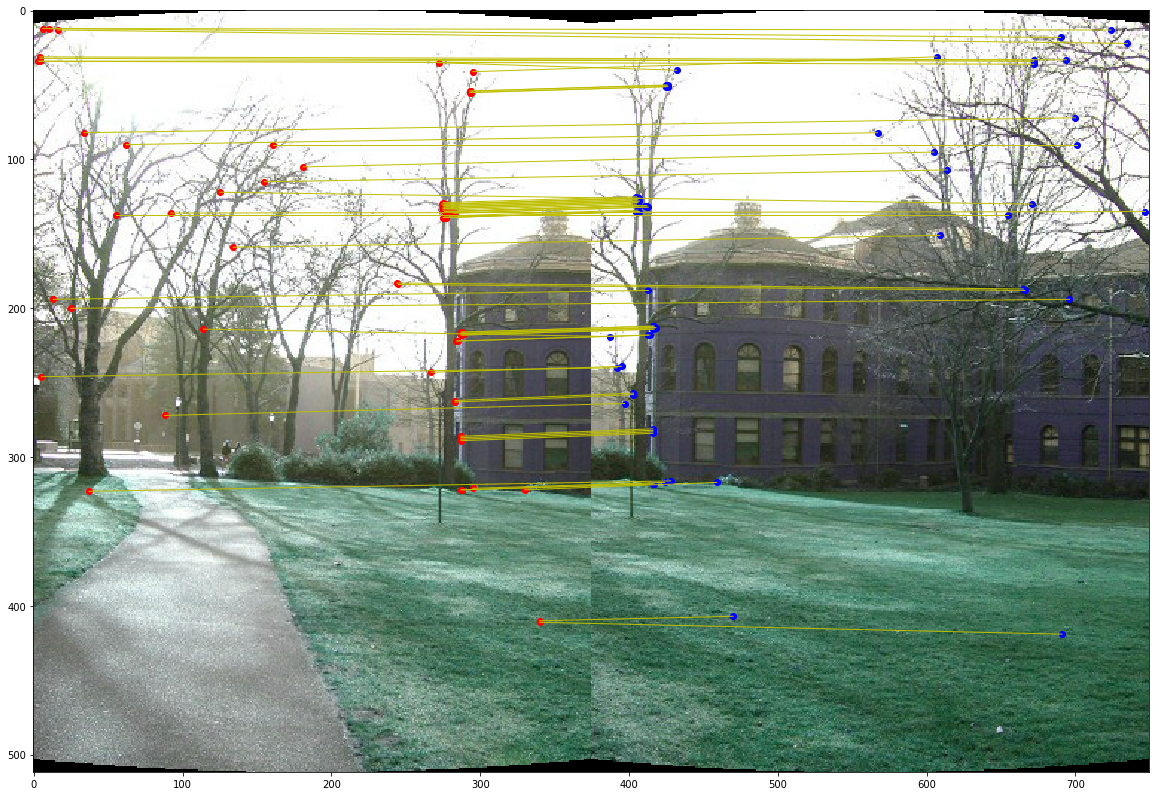

In [6]:
_, offset, _ = cylinder_img_list[1].shape
plt_img = np.concatenate((cylinder_img_list[1], cylinder_img_list[0]), axis=1)
plt.figure(figsize=(20,20))
plt.imshow(plt_img)
for i in range(len(mp)):
    plt.scatter(x=mp[i][1][1], y=mp[i][1][0], c='r')
    plt.plot([mp[i][1][1], offset+mp[i][0][1]], [mp[i][1][0], mp[i][0][0]], 'y-', lw=1)
    plt.scatter(x=offset+mp[i][0][1], y=mp[i][0][0], c='b')
plt.show()

In [13]:
# find best shift using RANSAC
def RANSAC(matched_pairs):
    matched_pairs = np.asarray(matched_pairs)
    
    best_shift = []
    K = 500
    threshold_distance = 20
    
    max_inliner = 0
    for k in range(K):
        
        # Random pick a pair of matched feature
        random_idx = int(np.random.random_sample()*len(matched_pairs))
        sample = matched_pairs[random_idx]
        
        # fit the warp model
        shift = sample[1] - sample[0]
        #print(sample)
        #print(shift)
        
        # calculate inliner points
        shifted = matched_pairs[:,1] - shift
        difference = matched_pairs[:,0] - shifted
        
        inliner = 0
        for diff in difference:
            if (diff**2).sum()**0.5 < threshold_distance:
                inliner = inliner + 1
        
        if inliner > max_inliner:
            max_inliner = inliner
            best_shift = shift
        
    return best_shift

In [14]:
shift = RANSAC(mp)

In [9]:
a=np.array([1,5])
print(a**2)
(a**2).sum()**0.5
shift

[ 1 25]


array([  4, 245])

In [56]:
def blending(img1, img2, shift):
    blended_img = []
    
    # img2 at lower-left
    if shift[0] > 0 and shift[1] > 0:
        shifted_img = np.lib.pad(img2, [(0, shift[0]), (0, shift[1]), (0, 0)], 'constant', constant_values=0)
        h, w, _ = img1.shape

        for y in range(h):
            for x in range(w):
                if list(shifted_img[y+shift[0]][x+shift[1]]) != [0,0,0]:
                    _, width, _ = img2.shape
                    color1 = shifted_img[y+shift[0]][x+shift[1]]
                    color2 = img1[y][x]
                    ratio = ((math.cos((x/(width-shift[1]))*3.14)+1)/2)**2
                    shifted_img[y+shift[0]][x+shift[1]] = (1-ratio)*color2 + ratio*color1
                else:
                    shifted_img[y+shift[0]][x+shift[1]] = img1[y][x]
        blended_img = shifted_img
  
    return blended_img  

In [57]:
shifted_img = blending(cylinder_img_list[0], cylinder_img_list[1], shift)

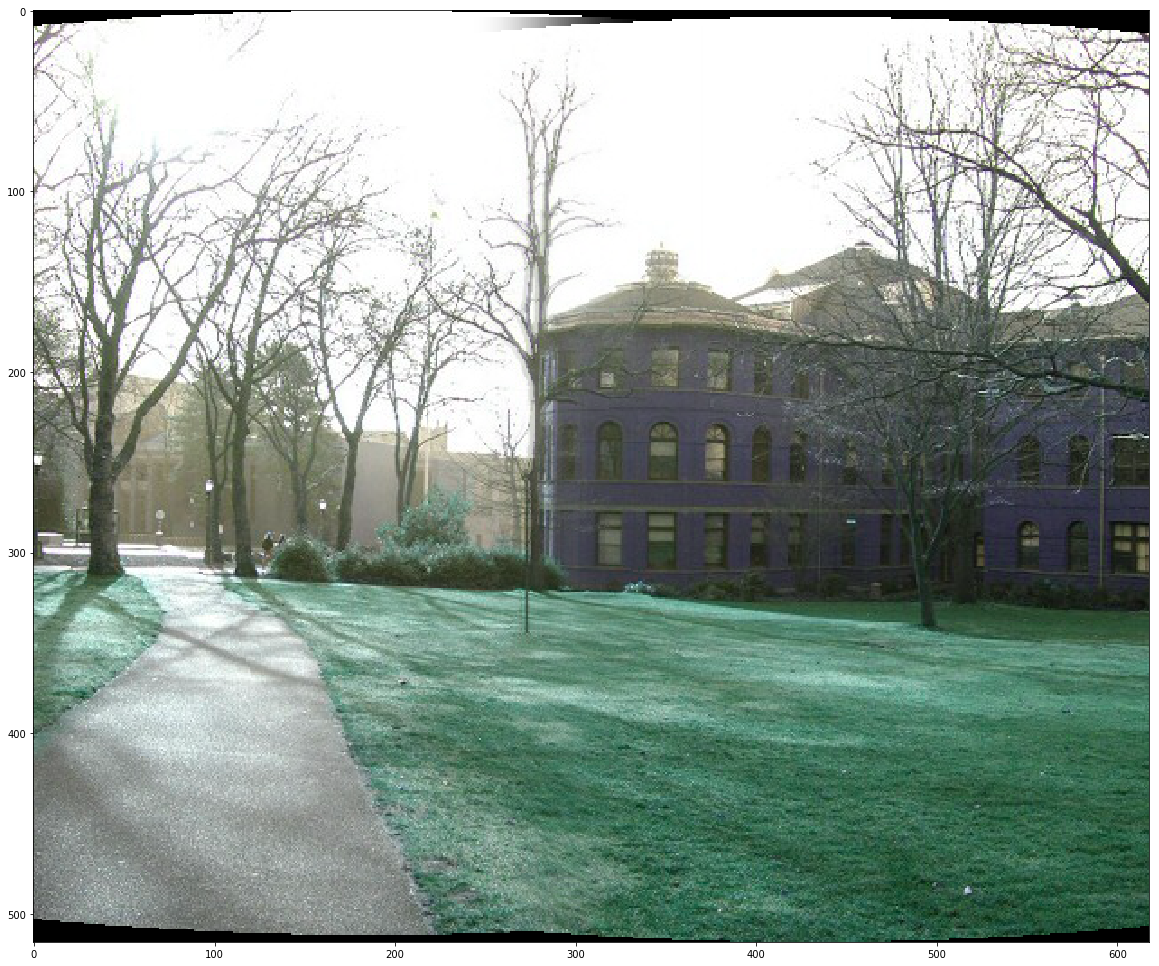

In [58]:
plt.figure(figsize=(20,20))
plt.imshow(shifted_img)
plt.show()

In [42]:
a=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
a**2

array([ 0.01,  0.04,  0.09,  0.16,  0.25,  0.36,  0.49,  0.64,  0.81,  1.  ])